# Restaurant Recommender
The goal of this project is to generate a restaurant recommender for users. The initial approach is to use unsupervised learnings methods to vectorize restaurants, with similar restaurants having similar space. This may be visualized through PCA. 

The restaurant vectors will come from the reviews of the various restaurants.

A user's feeling about a given restaurant will be taken from either A) their star rating, or B) sentiment analysis from their reviews. I will start with A given its simplicity, however with the caveat that not all 5-star reviews are alike (e.g. I could rate something 5-stars, but not necessarily want to go to a similar place again for various reasons).

**Customer/Use Case:** Potential user would be Yelp in order to increase user value of the platform, thereby improving customer aquisition, usage, and retention.

**Approach:** 
1) Data curation and EDA (accomplished in sperate notebooks)
2) Data cleaning
    * Reducing feature and data scope (**Initially PA only**)
    * We would likely only want to categorize restaurants that have a certain number of reviews in order to avoid noisy data.
3) Review aggregation and cutoff selection

    * All review data will be combined into a single field, with an initial df something like this:
| RestaurantId | RestaurantName | AllCombinedReviews |
| ------------ | -------------- | ------------------ |
| abcde...     | John's Place   | loved it was good, etc. | 

5) Featurize the review data
    * Review data will be features using **tf-idf**, but additional embeddings could be used as time permits.
    * Dimensionality reduction will be performed via non-negative matrix factorization
      * This will output a reduced feature set for the restaurants. Initial feature set will be 40, but could be tuned as time permits.
      * Matrix W will contain cluster centroids. Matrix H will contain cluster membership indicators
6)  Budilding out recommender
    * **Initial POC** using the business_id from a user's 5-star review, calculate a similiarity score to the other restaurants, and return three restaurants with the highest similarity that do not have the name name (in order to avoid recommended a different Starbucks to someone who likes Starbucks).
    * Could test with various similarity scores to see what works best.
7) Evaluate recommender
   * Evaluation will likely be a manual review given the unsupervised nature of the model
8) Deployment
   * This is a stretch goal. Would be cool to host on AWS for online input

In [1]:
# Importing all packages including NLTK downloads as necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk.corpus
import string
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity 
from collections import defaultdict
from tabulate import tabulate
import umap.umap_ as umap
from bokeh.palettes import viridis, Category20
first_run = False
if first_run:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
import dataprep

C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing and cleaning data

In [2]:
data_import = True
if data_import:
    business = pd.read_csv("yelp_dataset/yelp_academic_dataset_business.csv", low_memory=False)
    reviews = pd.read_csv("yelp_dataset/yelp_academic_dataset_review.csv")

### Filtering for PA restaurants only

In [3]:
# The review cleaning function take a long time. Filtering dataset before we go further.
clean_business = dataprep.clean_business_data(business)
PA_business = clean_business[clean_business['state'] == 'PA']

filtered_reviews = reviews[reviews['business_id'].isin(PA_business['business_id'])].copy()
PA_reviews = dataprep.clean_review_data(filtered_reviews)

In [4]:
# Filtering for only restaurants and slicing out only the columns that we may need going forward
PA_business['is_restaurant'] = PA_business.apply(lambda row: row['category_split'].count('restaurants') > 0, 
                                                 axis=1)
PA_restaurant = PA_business[PA_business['is_restaurant'] == True].reset_index(drop=True)[['business_id', 'name']]
PA_reviews = PA_reviews[['user_id', 'business_id', 'text', 'stars']]

C:\Users\chreddin\AppData\Local\Temp\ipykernel_37156\3235727762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PA_business['is_restaurant'] = PA_business.apply(lambda row: row['category_split'].count('restaurants') > 0,


**Note:** Another way to evaluate this is to look at star rating for various businesses that users have been to. For example, hold out a set of 5 star reviews for usersand see if my analysis would have predicted that they would have liked the place I recommended based on previous places that they liked. This could be a stretch goal, but a very cool way to validate the model.

## Joining datasets

In [5]:
PA_data = PA_restaurant.merge(PA_reviews, how='inner', on='business_id', validate='one_to_many')

In [6]:
# Generating a DataFrame with one row per business with all reviews aggregated into one column
PA_combined = PA_data.groupby('business_id', as_index=False).agg({'text':[' '.join, 'count'],
                                                                  'name': pd.Series.mode})
PA_combined.columns = ['business_id', 'reviews', 'num_reviews', 'name']

In [7]:
# filtering for businesses that have > min_reviews in order to avoid noisy data.
min_reviews = 5
PA_combined_filtered = PA_combined[PA_combined['num_reviews'] >= min_reviews].reset_index(drop=True)[['business_id', 'reviews', 'name']]

In [8]:
PA_combined_filtered.head()

,business_id,reviews,name
0,--ZVrH2X2QXBFdCilbirsw,this place is sadly perm closed i was hoping n...,chriss sandwich shop
1,--epgcb7xHGuJ-4PUeSLAw,love their asiago roll that and a cup of coffe...,manhattan bagel
2,-0FX23yAacC4bbLaGPvyxw,it was our first visit to the restaurant under...,the grey stone fine food and spirits
3,-0M0b-XhtFagyLmsBtOe8w,review of paris flea market accidentally poppe...,paris wine bar
4,-0PN_KFPtbnLQZEeb23XiA,while there didnt seem to be anything wrong wi...,mr wongs chinese restaurant


## Getting embeddings from tf-idf for featurization

In [9]:
# Identifying stopwords from multiple sources
my_stopwords = ['review']
nltk_stop_words = list(nltk.corpus.stopwords.words('english'))
nltk_stop_words = [word.translate(str.maketrans('', '', string.punctuation)) for word in nltk_stop_words]
stopwords = list(set(list(ENGLISH_STOP_WORDS) + my_stopwords + nltk_stop_words))

In [10]:
# Lemmatizing words
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        
tf = TfidfVectorizer(strip_accents='unicode',
                     tokenizer=LemmaTokenizer(),
                     stop_words=stopwords,
                     max_features=500) # Setting at 500 for POC. Could be tuned further

In [11]:
# Could use train/test split to calculate reconstruction errors using k-fold cross validation

# X_train, X_test , y_train, y_test = train_test_split(PA_data['text'].values,
#                                                      PA_data['is_restaurant'].values, 
#                                                      test_size=0.25, 
#                                                      random_state=43)

In [12]:
# Could use n-grams here
tfidf = tf.fit_transform(PA_combined_filtered['reviews'].values) #ngram_range=(1, 2)) #Including uni and bi-grams

C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\chreddin\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [13]:
tfidf.shape

(12641, 500)

## Fitting NMF 

In [14]:
num_components = 20
nmf = NMF(n_components=num_components, max_iter=600) # n_components is being set arbitrarily but could be tuned as time permits
nmf.fit(tfidf)

H = nmf.components_
W = nmf.transform(tfidf)

Above, we selected n_components arbitrarily, but we could have trained a number of models and plotted the "coherence score" for each output topic in the model. The gensim library provides for doing this.

It would output a coherence score for each number of n_components which could be plotted as such:

![image](Images/coherence_score.png)

Local minima (red dashed lines) would be good targets for n_components candidates after testing.

Additional information can be found here: [https://radimrehurek.com/gensim/models/coherencemodel.html](https://radimrehurek.com/gensim/models/coherencemodel.html)



In [15]:
print(H.shape)
print(W.shape)

(20, 500)
(12641, 20)


### Examining NMF latent features

In [16]:
# Examining the top words for each latent feature
words = tf.get_feature_names_out()
top_words_index = np.argsort(-H)[:,0:10]
most_common_words_per_topic = np.array(words)[top_words_index]
for i, items in enumerate(most_common_words_per_topic):
    print(i, items)

0 ['wa' 'u' 'came' 'table' 'ordered' 'server' 'restaurant' 'service'
 'waitress' 'got']
1 ['pizza' 'wa' 'crust' 'delivery' 'slice' 'pie' 'place' 'good' 'order'
 'cheese']
2 ['coffee' 'cafe' 'place' 'shop' 'great' 'good' 'tea' 'drink' 'wa'
 'friendly']
3 ['chinese' 'food' 'rice' 'place' 'chicken' 'dumpling' 'wa' 'good' 'soup'
 'fried']
4 ['sushi' 'roll' 'tuna' 'wa' 'place' 'good' 'fresh' 'salmon' 'fish' 'spicy']
5 ['bar' 'beer' 'bartender' 'place' 'drink' 'great' 'good' 'food' 'night'
 'selection']
6 ['taco' 'mexican' 'burrito' 'food' 'wa' 'chip' 'place' 'good' 'authentic'
 'margarita']
7 ['order' 'food' 'wa' 'time' 'location' 'customer' 'service' 'minute'
 'employee' 'like']
8 ['sandwich' 'wa' 'salad' 'bread' 'lunch' 'good' 'fresh' 'place' 'great'
 'meat']
9 ['breakfast' 'food' 'diner' 'egg' 'place' 'toast' 'pancake' 'good' 'great'
 'bacon']
10 ['burger' 'fry' 'food' 'good' 'wa' 'bun' 'place' 'bacon' 'onion' 'cheese']
11 ['indian' 'food' 'wa' 'chicken' 'curry' 'place' 'lamb' 'rice' 'go

In looking through the above features, it appears that most of the features have clear categories (e.g. #1 is Pizza, #6 is mexican, #19 is seafood, etc.). Most of the features have captured cuisine which makes sense as this is the most significant restaurant differentiator as opposed to service quality or location.

In [17]:
# Plotting the latent features after dimensionality reduction.
umap_embr = umap.UMAP(n_neighbors=10, metric='cosine', min_dist=0.1)#, random_state=42)
embedding = umap_embr.fit_transform(tfidf)
embedding = pd.DataFrame(embedding, columns=['x','y'])
centroids = umap_embr.transform(nmf.components_)
embedding['hue'] = W.argmax(axis=1)

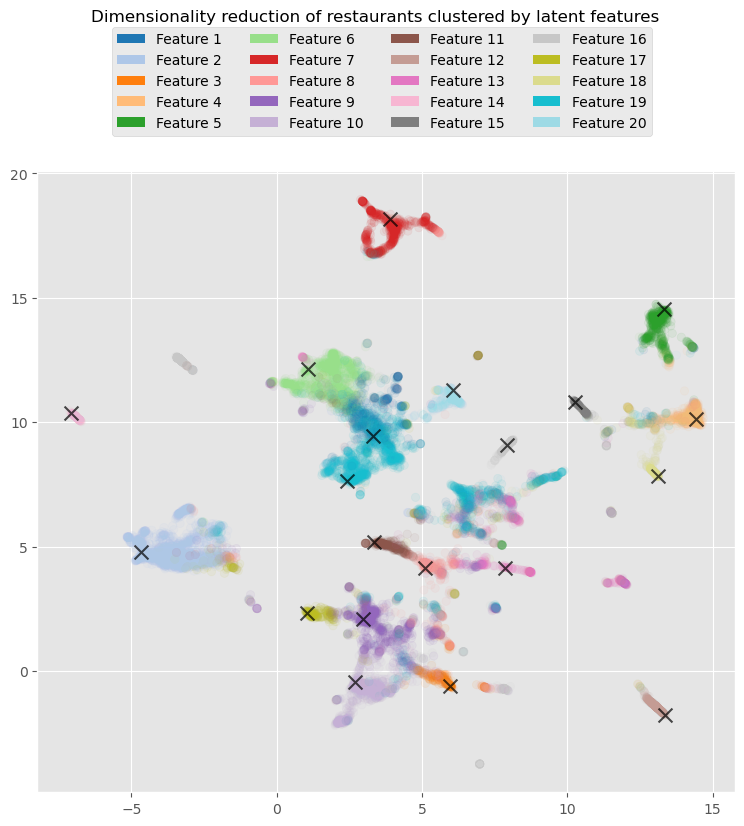

In [18]:
fig, ax = plt.subplots(figsize=(9, 9))
legend_list = []
if num_components <= 20:
    my_colors = [Category20[num_components][i] for i in embedding.hue]
    for color in Category20[num_components]:
        legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
else:
    my_colors = [viridis(num_components)[i] for i in embedding.hue]
    for color in viridis(num_components):
        legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
features = ['Feature {}'.format(i) for i in range(1, num_components+1)]
ax.scatter(embedding['x'], embedding['y'], c=my_colors, alpha=0.07)
ax.scatter(centroids[:,0], centroids[:,1], c='black', s=100, alpha=0.7, marker='x')
plt.suptitle('Dimensionality reduction of restaurants clustered by latent features')
plt.subplots_adjust(top=0.8)
fig.legend(legend_list, features, loc=(0.15,0.835), ncol=4)

plt.show()

Generally, we're seeing pretty good separation of restaurants with the selected number of latent features. There is some mix up in the middle so it could be that >20 latent features would capture more signal.

In [19]:
# Identifying the top restaurants for each latent feature
rest_dict = defaultdict(list)
for index, restaurant in enumerate(W):
    key = np.argmax(restaurant)
    value = restaurant[key]
    name = PA_combined_filtered['name'][index]
    rest_dict[key].append([value, name])
top_restaurants = defaultdict(list)
for feature in rest_dict:
    top_restaurants[feature] = list(np.sort(np.array(rest_dict[feature]).T)[1,-5:])
for key, value in sorted(top_restaurants.items()):
    print(key, value)

0 ['wyndham alumnae house', 'xilantro', 'yamitsuki ramen', 'yard house', 'yardley country club']
1 ['zesty pizza', 'zio pizza palace  grill', 'zios brick oven pizzeria', 'zoe', 'zuzus kitchen']
2 ['wawa', 'wawa food markets', 'wawa food markets', 'wired beans cafe', 'yolo']
3 ['yummi yummi', 'yummy yummy', 'zhangs china house', 'zhi wei guan  magic kingdom of dough', 'zhous house chinese restaurant']
4 ['zama', 'zento contemporary japanese cuisine', 'zhi izakaya', 'zushi', 'zw sushi land']
5 ['ye olde meetinghouse tavern', 'yeats pub', 'yellobar', 'zincbar', 'zot']
6 ['xochi modern taqueria  more', 'xochitl', 'xolo tacos', 'yosemite burrito', 'zocalo']
7 ['wendys', 'wendys', 'wendys', 'wingstop', 'wolfs market']
8 ['zoup', 'zoup', 'zoup', 'zoup', '¡juice']
9 ['zakes cafe', 'zekes fifth street deli bakery', 'zinas kitchen', 'zoes cafe', 'zotos diner']
10 ['zacs hamburgers', 'zacs hamburgers', 'zacs hamburgers', 'zacs hamburgers', 'zacs hamburgers']
11 ['youma', 'zaika', 'zaika kabab  cu

## Identifying restaurants that are the most similar to one another

### Adding the W matrix back to the original dataset

In [20]:
columns = ['feature{}'.format(n) for n in range(0, num_components)]
W_df = pd.DataFrame(W, columns=columns)
PA_business_features = pd.concat([PA_combined_filtered[['business_id', 'name']], W_df], axis=1)

In [21]:
PA_business_features.head(2)

,business_id,name,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19
0,--ZVrH2X2QXBFdCilbirsw,chriss sandwich shop,0.000000,0.019974,0.004186,0.0,0.0000,0.005343,0.0,0.005688,0.148019,0.0,0.0,0.000000,0.0,0.000000,0.0,0.010008,0.015598,0.0,0.038516,0.0
1,--epgcb7xHGuJ-4PUeSLAw,manhattan bagel,0.012848,0.000000,0.013788,0.0,0.0029,0.003324,0.0,0.028231,0.020537,0.0,0.0,0.000057,0.0,0.178949,0.0,0.000000,0.000000,0.0,0.003801,0.0


### Calculating cosine similarity

In [22]:
similarity_array = cosine_similarity(PA_business_features.iloc[:,2:])
similarity_df = pd.DataFrame(similarity_array, columns=PA_combined_filtered['business_id'])
PA_business_similarity = pd.concat([PA_combined_filtered[['business_id', 'name']], similarity_df], axis=1)

In [23]:
PA_business_similarity.shape

(12641, 12643)

In [24]:
PA_business_similarity.iloc[:5,:6]

,business_id,name,--ZVrH2X2QXBFdCilbirsw,--epgcb7xHGuJ-4PUeSLAw,-0FX23yAacC4bbLaGPvyxw,-0M0b-XhtFagyLmsBtOe8w
0,--ZVrH2X2QXBFdCilbirsw,chriss sandwich shop,1.000000,0.119929,0.183564,0.158809
1,--epgcb7xHGuJ-4PUeSLAw,manhattan bagel,0.119929,1.000000,0.073662,0.057365
2,-0FX23yAacC4bbLaGPvyxw,the grey stone fine food and spirits,0.183564,0.073662,1.000000,0.858229
3,-0M0b-XhtFagyLmsBtOe8w,paris wine bar,0.158809,0.057365,0.858229,1.000000
4,-0PN_KFPtbnLQZEeb23XiA,mr wongs chinese restaurant,0.000000,0.000000,0.000000,0.000000


## Evaulating/testing on user reviews

In [25]:
five_star_reviews = PA_data[PA_data['stars'] == 5]
sample_reviews = five_star_reviews.sample(5, random_state=42)
sample_reviews

,business_id,name,user_id,text,stars
90697,wUnLSg_GKfEIQ5CQQ770_g,vetri cucina,Iv9H9sRk2pMxizrcM_86vw,i absolutely love this restaurant offers a bea...,5.0
569309,4NlSpFSdeexT30ZJ_Rabxw,dinapolis italian market restaurant and catering,SfO3PS1-xTVT0T91eA87zg,my dad and i took a trip to new hope and came ...,5.0
491116,6M5r34Sk3mC6kCVXLYKrag,the better box,JvUPonIfl51OeVVlKZ4Fmw,excellent food love the twist on traditional f...,5.0
263859,e3Y3hDpwHc9RmQlJtIgHuw,lacroix restaurant at the rittenhouse,EBrBIRZSvxcDKI70uH61Wg,brunch at lacroix mind blown im not a breakfas...,5.0
994892,cxbHM3CdEI0FM6T-ybhl1A,mcstews irish pub,CFd994mNY5JC_2HdV4XApg,ive been coming to this establishment for quit...,5.0


In [26]:
def top_recommendations(business_id, similarity_matrix, top_n=3, name_filter=True):
    df = similarity_matrix[similarity_matrix['business_id'] == business_id]
    name_mapping = similarity_matrix[['business_id', 'name']]
    if name_filter:
        business_ids_to_filter = name_mapping[name_mapping['name'] == df['name'].values[0]]['business_id'].values
    else:
        business_ids_to_filter = business_id
    df = df.drop(business_ids_to_filter, axis=1)
    output = df.T.iloc[2:,:].sort_values(by=df.T.columns[0], ascending=False).iloc[:top_n,:].reset_index()
    output.columns = ['business_id', 'similarity']
    output = output.merge(name_mapping, how='left', on='business_id')
    return output   

In [27]:
for i in range(sample_reviews.shape[0]):
    print(sample_reviews.iloc[i]['name'])
    print(tabulate(top_recommendations(sample_reviews.iloc[i]['business_id'], PA_business_similarity, top_n=2, name_filter=True),
                  showindex=False,
                  headers='keys',
                  tablefmt='psql'))
    print()

vetri cucina
+------------------------+--------------+--------------+
| business_id            |   similarity | name         |
|------------------------+--------------+--------------|
| 5GtZaOCAZejU_z_i2MfZxw |     0.999801 | verbena byob |
| qnprJxrjwuEivitA8V2aEQ |     0.999189 | fiorella     |
+------------------------+--------------+--------------+

dinapolis italian market restaurant and catering
+------------------------+--------------+--------------------------+
| business_id            |   similarity | name                     |
|------------------------+--------------+--------------------------|
| xVSFZ-STvN-9jUJxaPLAWA |     0.982491 | red tomato               |
| WIicEEmnWe10TYHajblM0Q |     0.980936 | la stalla italian market |
+------------------------+--------------+--------------------------+

the better box
+------------------------+--------------+------------------------+
| business_id            |   similarity | name                   |
|------------------------+-----

Based on a cursery review of the restaurant names above, it appears that the recommender is doing a pretty good job -- at least at finding similar cuisine.

#### Digging into vetri cucina in particular

![image](Images/VetriHeader.png)

![image](Images/Vetri.png)

[Yelp link](https://www.yelp.com/biz/vetri-cucina-philadelphia)


![image](Images/VerbenaHeader.png)

![image](Images/Verbena.png)

[Yelp link](https://www.yelp.com/biz/verbena-byob-kennett-square)


![image](Images/FiorellaHeader.png)

![image](Images/Fiorella.png)

[Yelp link](https://www.yelp.com/biz/fiorella-philadelphia-2)


**Similarities**
* Food generally looks similar
* Similar reviews
* Fine dining
* Price range
* Ambiance
* 2 are Italian

## Conclusion & Future Work
Overall, this fairly simple recommender appears to do a pretty good job recommending similar restaurants based on a manual review of the latent features and the recommendations. Before making this user facing, I would want to do futher analysis to see how the rating distribution for a given user was materially different than the ratings that they may have actually given to some of the recommended restaurants. However, if that proves not to be feasible, another use case could be to use this recommender to try and generate more reviews by asking the user if they have been to any similiar restaurants and prompting them for reviews. 

There are many ways that this work could be taken further:
1) Incorporating other non-text fields (e.g. ZipCode, lat/lon for business, etc.) to see if it improves the model.
2) Using the same features to provide the user more options (e.g. Only recommend restaurants within X kilometers from me).
3) Expanding the data set or use case to recommend outside of the set geo (e.g. If a user is traveling)
4) Tuning the number of latent features
5) Featurzing with n-grams instead of only unigrams
6) Using different word embeddings (Word2Vec)